**SENTIMENT ANALYSIS OF MOVIE REVIEW USING CNN**
**-SOUMYA VATS & ARUSHI GARG**
**ECE, 1st YEAR**
**IGDTUW**


The purpose of this program is to perform Sentiment Analysis on Movie Reviews using Convolution Neural Network

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We will first import required packages that we will be using subsequently through the program.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib  
from matplotlib import pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.wrappers.scikit_learn import KerasClassifier
import string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.layers import LSTM,Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import LSTM, Conv1D, MaxPooling1D, Dropout
from keras.callbacks import EarlyStopping

Now we will import the movie reviews data that is stored as a CSV file on Google Drive.


In [ ]:
#importing the training data
data=pd.read_csv(r'/content/drive/MyDrive/IMDB Dataset.csv')
print(data.shape)
data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [ ]:
#Summary of the dataset
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


As we can see above, there are total 50000 reviews with 49582 unique reviews.


In [ ]:
# 0 as Negative and 1 as Positive
data.sentiment=data.sentiment.apply(lambda x: 0 if x=='negative' else 1)

In [ ]:
##### WORD ANALYSIS #####

In [ ]:
#WORD ANALYSIS OF TRAINING DATASET
# Indirect features
import nltk
nltk.download('stopwords')
eng_stopwords = set(stopwords.words("english"))
#count of sentences
data['count_sent']=data["review"].apply(lambda x: len(re.findall("/n",str(x)))+1)
#Word count in each comment:
data['count_word']=data["review"].apply(lambda x: len(str(x).split()))
#Unique word count
data['count_unique_word']=data["review"].apply(lambda x: len(set(str(x).split())))
#Letter count
data['count_letters']=data["review"].apply(lambda x: len(str(x)))
#punctuation count
data["count_punctuations"] =data["review"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
data["count_words_upper"] = data["review"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
data["count_words_title"] = data["review"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
data["count_stopwords"] = data["review"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#Average length of the words
data["mean_word_len"] = data["review"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
#Word count percent in each comment:
data['word_unique_percent']=data['count_unique_word']*100/data['count_word']
#Punct percent in each comment:
data['punct_percent']=data['count_punctuations']*100/data['count_word']
#derived features
#Word count percent in each comment:
data['word_unique_percent']=data['count_unique_word']*100/data['count_word']
#derived features
#Punct percent in each comment:
data['punct_percent']=data['count_punctuations']*100/data['count_word']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
## Reordering the columns 
data = data[['review', 'count_sent', 'count_word', 'count_unique_word',
       'count_letters', 'count_punctuations', 'count_words_upper',
       'count_words_title', 'count_stopwords', 'mean_word_len',
      'word_unique_percent', 'punct_percent','sentiment']]
data.head(15)

,review,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,word_unique_percent,punct_percent,sentiment
0,One of the other reviewers has mentioned that ...,1,307,208,1761,78,8,36,133,4.739414,67.752443,25.407166,1
1,A wonderful little production. <br /><br />The...,1,162,114,998,44,2,12,66,5.166667,70.370370,27.160494,1
2,I thought this was a wonderful way to spend ti...,1,166,121,926,40,3,20,76,4.584337,72.891566,24.096386,1
3,Basically there's a family where a little boy ...,1,138,96,748,42,3,13,62,4.427536,69.565217,30.434783,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,230,152,1317,56,1,31,96,4.730435,66.086957,24.347826,1
5,"Probably my all-time favorite movie, a story o...",1,119,97,656,28,1,10,59,4.521008,81.512605,23.529412,1
6,I sure would like to see a resurrection of a u...,1,150,98,726,12,7,7,74,3.846667,65.333333,8.000000,1
7,"This show was an amazing, fresh & innovative i...",1,174,122,934,33,4,10,86,4.373563,70.114943,18.965517,0
8,Encouraged by the positive comments about this...,1,130,100,681,31,2,11,57,4.246154,76.923077,23.846154,0
9,If you like original gut wrenching laughter yo...,1,33,26,176,12,0,4,14,4.363636,78.787879,36.363636,1


In [ ]:
data.groupby(['sentiment'],as_index=False).mean()

,sentiment,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,word_unique_percent,punct_percent
0,0,1.00224,229.46456,152.2662,1294.06436,53.59836,5.14632,24.72780,103.38132,4.623461,70.896372,23.447622
1,1,1.00196,232.84932,152.0156,1324.79768,51.55876,4.56928,27.96804,104.31900,4.657892,70.164729,22.077985


In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Now we will begin cleaning the data by removing punctuation, removing stopwords etc.

In [ ]:
###### CLEANING THE DATA SET###### 

In [ ]:
# Removing all punctuations from Text
mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't":"shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

#removing stopwords and word processing

def word_replace(text):
    return text.replace('<br />','')

from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)
def preprocess(text):
    text=clean_contractions(text,mapping)
    text=text.lower()
    text=word_replace(text)
    text=remove_urls(text)
    text=remove_html(text)
    text=remove_stopwords(text)
    text=remove_punctuation(text)
#     text=stem_words(text) ## Takes too much of time
    text=lemmatize_words(text)
    return text

In [ ]:
#REPRESENTATION OF THE PROCESSED DATA IN TABULAR FORM
import nltk
nltk.download('wordnet')
data["reviews_p"] = data["review"].apply(lambda text: preprocess(text))
data.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,review,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,word_unique_percent,punct_percent,sentiment,reviews_p
0,One of the other reviewers has mentioned that ...,1,307,208,1761,78,8,36,133,4.739414,67.752443,25.407166,1,one reviewer mentioned watching 1 oz episode h...
1,A wonderful little production. <br /><br />The...,1,162,114,998,44,2,12,66,5.166667,70.370370,27.160494,1,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,1,166,121,926,40,3,20,76,4.584337,72.891566,24.096386,1,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,1,138,96,748,42,3,13,62,4.427536,69.565217,30.434783,0,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,230,152,1317,56,1,31,96,4.730435,66.086957,24.347826,1,petter matteis love time money visually stunni...


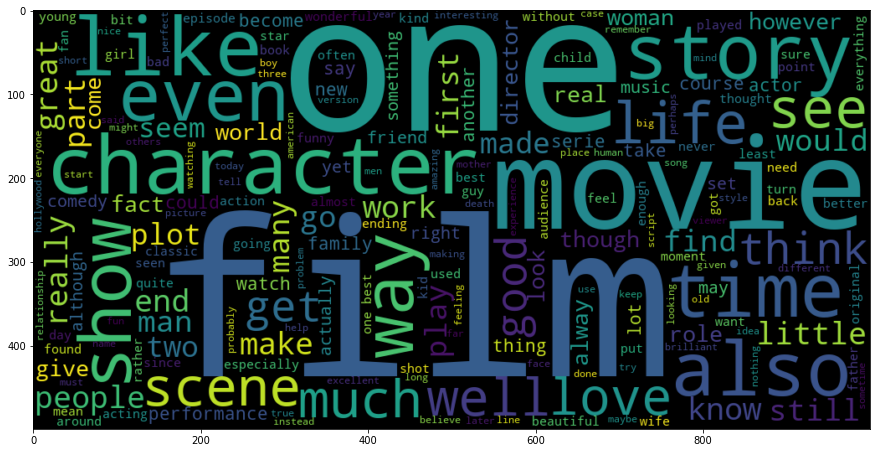

In [ ]:
#Positive reviews
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 200 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(data[data.sentiment == 1].reviews_p))
plt.imshow(wc , interpolation = 'bilinear')

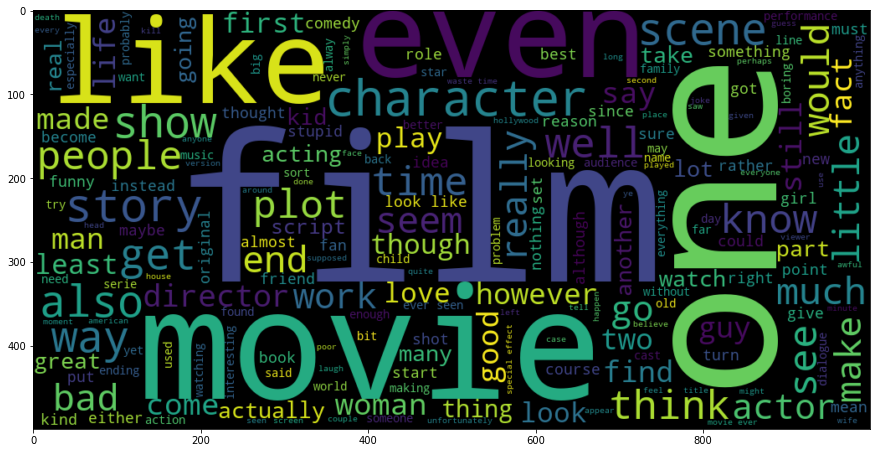

In [ ]:
# Negative Reviews.
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 200 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(data[data.sentiment == 0].reviews_p))
plt.imshow(wc , interpolation = 'bilinear')


From these word clouds, we are not able to judge any starling differences in both the sentiments by looking at words. We don’t see usage of extreme negative connotation or abusive language used while writing negative reviews.

In [ ]:
#####Utility Function#####

In [ ]:
def metrics(model,x,y):
    y_pred = model.predict(x)
    acc = accuracy_score(y, y_pred)
    f1=f1_score(y, y_pred)
    cm=confusion_matrix(y, y_pred)
    report=classification_report(y,y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm,annot=True,cmap='coolwarm',xticklabels=[0,1],fmt='d',annot_kws={"fontsize":19})
    plt.xlabel("Predicted",fontsize=16)
    plt.ylabel("Actual",fontsize=16)
    plt.show()
    print("\nAccuracy: ",round(acc,2))
    print("\nF1 Score: ",round(f1,2))
    print("\nConfusion Matrix: \n",cm)
    print("\nReport:",report)

In [ ]:
X=data[['count_sent', 'count_word', 'count_unique_word',
       'count_letters', 'count_punctuations', 'count_words_upper',
       'count_words_title', 'count_stopwords', 'mean_word_len',
       'word_unique_percent', 'punct_percent']]
y=data['sentiment']

Selecting numerical features for training model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=0)

In [ ]:
[i.shape for i in [X_train, X_test, y_train, y_test] ]

[(40000, 11), (10000, 11), (40000,), (10000,)]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


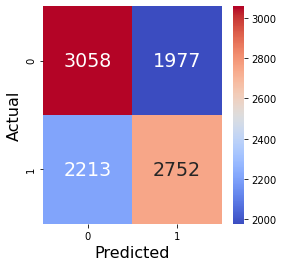


Accuracy:  0.58

F1 Score:  0.57

Confusion Matrix: 
 [[3058 1977]
 [2213 2752]]

Report:               precision    recall  f1-score   support

           0       0.58      0.61      0.59      5035
           1       0.58      0.55      0.57      4965

    accuracy                           0.58     10000
   macro avg       0.58      0.58      0.58     10000
weighted avg       0.58      0.58      0.58     10000



In [ ]:
# Logistic Regression with Indirect features
classifier = LogisticRegression(C=0.1, solver='sag')
classifier.fit(X_train, y_train)
metrics(classifier,X_test,y_test)

Accuracy after applying Logistic Regression = 58%

In [ ]:
##### PROCESSING USING TEXTBLOB LIBRARY #####

Unsupervised- Pre-trained model- TextBlob

In [ ]:
from textblob import TextBlob

In [ ]:
def get_sentiment( tweet):
        analysis = TextBlob(tweet)
      
        if analysis.sentiment.polarity > 0:
            return 'positive'
        else:
            return 'negative'

In [ ]:
data['TextBlob']=data['reviews_p'].apply(lambda x: get_sentiment(x))

In [ ]:
print(data.TextBlob.value_counts())
print("\n",data.sentiment.value_counts())

positive    36959
negative    13041
Name: TextBlob, dtype: int64

 1    25000
0    25000
Name: sentiment, dtype: int64


In [ ]:
data['TextBlob1']=data.TextBlob.apply(lambda x: 0 if x=='negative' else 1)


In [ ]:
accuracy_score(data.sentiment,data.TextBlob1)

0.69598

Accuracy after using TextBlob Library= 69.59% 

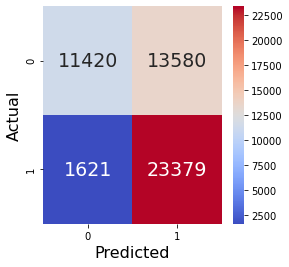

In [ ]:
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix(data.sentiment,data.TextBlob1),annot=True,cmap='coolwarm',xticklabels=[0,1],fmt='d',annot_kws={"fontsize":19})
plt.xlabel("Predicted",fontsize=16)
plt.ylabel("Actual",fontsize=16)
plt.show()

This model gives us accuracy of 69%. This model is not able to perform the best way possible as negative reviews contain any negative words. We know, after assigning individual scores to all the words, final sentiment is calculated by some pooling operation like taking an average of all the sentiments

In [ ]:
##### N-GRAM ANALYSIS ######

In [ ]:
texts = ' '.join(data['reviews_p'])

In [ ]:
string = texts.split(" ")

In [ ]:
def draw_n_gram(string,i):
    n_gram = (pd.Series(nltk.ngrams(string, i)).value_counts())[:7]
    n_gram_df=pd.DataFrame(n_gram)
    n_gram_df = n_gram_df.reset_index()
    n_gram_df = n_gram_df.rename(columns={"index": "word", 0: "count"})
    print(n_gram_df.head())
    plt.figure(figsize = (10,5))
    return sns.barplot(x='count',y='word', data=n_gram_df)

       word  count
0  (movie,)  98938
1   (film,)  89753
2    (one,)  52648
3   (like,)  39780
4  (would,)  30291


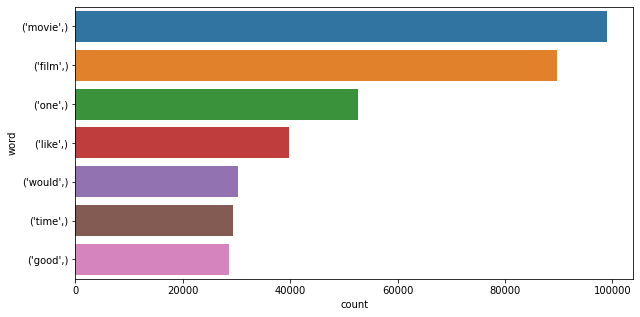

In [ ]:
#Unigram Analysis
draw_n_gram(string,1)

                word  count
0       (look, like)   2874
1       (ever, seen)   2534
2  (special, effect)   2198
3      (movie, ever)   1937
4  (main, character)   1875


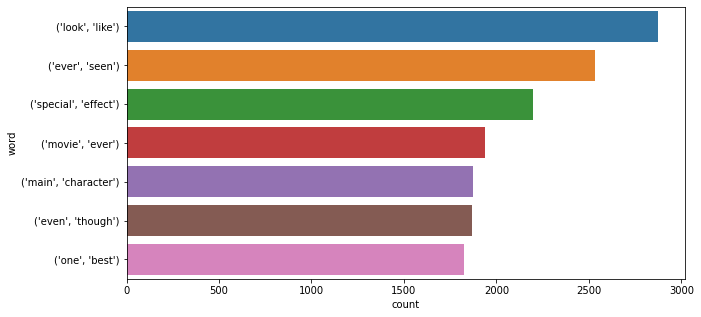

In [ ]:
#Bigram Analysis
draw_n_gram(string,2)

                   word  count
0   (movie, ever, seen)    828
1  (worst, movie, ever)    731
2    (film, ever, seen)    413
3   (worst, film, ever)    344
4   (movie, ever, made)    337


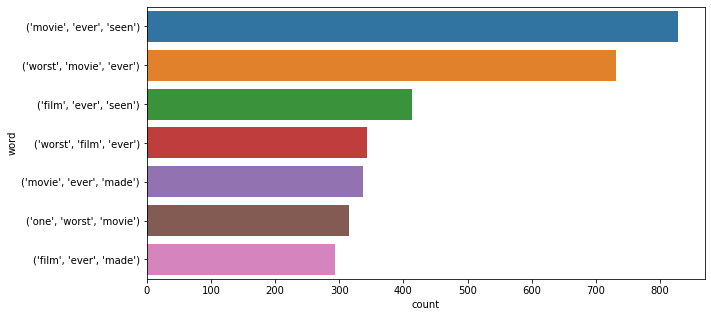

In [ ]:
#Trigram Analysis
draw_n_gram(string,3)

This N gram analysis showcase words which are occurring together in IMDB data base. From Uni gram we see that ‘Movie’ word occurs more than 1L times in dataset, which is quite obvious. From Bi gram, we see that ‘look like’ and ‘ever seen’ words have occurred more than 2500 times together From Tri gram, we see that ‘movie ever seen ’ has observed maximum number of times together.

In [ ]:
##### WORD EMBEDDING #####

In [ ]:
##### FREQUENCY BASED VECTORISATION #####

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['reviews_p'], data['sentiment'], test_size=0.2,random_state=0)

In [ ]:
[i.shape for i in [X_train, X_test, y_train, y_test] ]

[(40000,), (10000,), (40000,), (10000,)]

In [ ]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 3),
    max_features=10000
)

word_vectorizer.fit(data['reviews_p'])

tfidf_train = word_vectorizer.transform(X_train)
tfidf_test = word_vectorizer.transform(X_test)

In [ ]:
print('Shape of tfidf_train:',tfidf_train.shape)
print('Shape of tfidf_test:',tfidf_test.shape)

Shape of tfidf_train: (40000, 10000)
Shape of tfidf_test: (10000, 10000)


In [ ]:
##### COUNT VECTORISATION #####

In [ ]:
cv=CountVectorizer(analyzer = 'word', token_pattern = r'\w{1,}',ngram_range=(1,3),max_features=10000)
cv.fit(data['reviews_p'])
cv_train=cv.transform(X_train)
cv_test=cv.transform(X_test)

In [ ]:
print('Shape of cv_train:',cv_train.shape)
print('Shape of cv_test:',cv_test.shape)

Shape of cv_train: (40000, 10000)
Shape of cv_test: (10000, 10000)


In [ ]:
##### CNN #####

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data.reviews_p)
embedding_dim = 50
maxlen = 150

X_train, X_test, y_train, y_test = train_test_split(data['reviews_p'], data['sentiment'],test_size=0.2, random_state=0)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,test_size=0.1, random_state=0)

X_train1 = tokenizer.texts_to_sequences(X_train)
X_valid1 = tokenizer.texts_to_sequences(X_valid)
X_test1 = tokenizer.texts_to_sequences(X_test)

X_train1 = pad_sequences(X_train1, padding='post', maxlen=maxlen)
X_valid1 = pad_sequences(X_valid1, padding='post', maxlen=maxlen)
X_test1 = pad_sequences(X_test1, padding='post', maxlen=maxlen)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
embedding_vecor_length = 32
callback = EarlyStopping(monitor='val_loss', patience=2)

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 50)           10554700  
_________________________________________________________________
conv1d (Conv1D)              (None, 150, 32)           4832      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 75, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 75, 32)            3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 37, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 37, 32)            3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 18, 32)            0

In [ ]:
model.fit(X_train1, y_train, epochs=10, batch_size=256,verbose = 1,validation_data=(X_valid1,y_valid),callbacks=[callback])

Epoch 1/10
141/141 [==============================] - 53s 212ms/step - loss: 0.6607 - accuracy: 0.5728 - val_loss: 0.5727 - val_accuracy: 0.6599
Epoch 2/10
141/141 [==============================] - 29s 206ms/step - loss: 0.5540 - accuracy: 0.6779 - val_loss: 0.5677 - val_accuracy: 0.6638
Epoch 3/10
141/141 [==============================] - 29s 207ms/step - loss: 0.5439 - accuracy: 0.6801 - val_loss: 0.5638 - val_accuracy: 0.6669
Epoch 4/10
141/141 [==============================] - 29s 206ms/step - loss: 0.5314 - accuracy: 0.6887 - val_loss: 0.5647 - val_accuracy: 0.6641
Epoch 5/10
141/141 [==============================] - 29s 207ms/step - loss: 0.5222 - accuracy: 0.6941 - val_loss: 0.5668 - val_accuracy: 0.6635


Accuracy after using CNN model=64.4%


In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data.reviews_p)
embedding_dim = 50
maxlen = 150

X_train, X_test, y_train, y_test = train_test_split(data['reviews_p'], data['sentiment'],test_size=0.2, random_state=0)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,test_size=0.1, random_state=0)

X_train1 = tokenizer.texts_to_sequences(X_train)
X_valid1 = tokenizer.texts_to_sequences(X_valid)
X_test1 = tokenizer.texts_to_sequences(X_test)

X_train1 = pad_sequences(X_train1, padding='post', maxlen=maxlen)
X_valid1 = pad_sequences(X_valid1, padding='post', maxlen=maxlen)
X_test1 = pad_sequences(X_test1, padding='post', maxlen=maxlen)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
embedding_vecor_length = 32
callback = EarlyStopping(monitor='val_loss', patience=2)

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 50)           10554700  
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 150, 32)           4832      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 75, 32)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 75, 32)            3104      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 37, 32)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 37, 32)            3104      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 18, 32)           

In [ ]:
model.fit(X_train1, y_train, epochs=10, batch_size=256,verbose = 1,validation_data=(X_valid1,y_valid),callbacks=[callback])

Epoch 1/10
141/141 [==============================] - 47s 312ms/step - loss: 0.5800 - accuracy: 0.6395 - val_loss: 0.3041 - val_accuracy: 0.8690
Epoch 2/10
141/141 [==============================] - 40s 281ms/step - loss: 0.2354 - accuracy: 0.9085 - val_loss: 0.2845 - val_accuracy: 0.8788
Epoch 3/10
141/141 [==============================] - 40s 282ms/step - loss: 0.1781 - accuracy: 0.9366 - val_loss: 0.3146 - val_accuracy: 0.8745
Epoch 4/10
141/141 [==============================] - 39s 279ms/step - loss: 0.1065 - accuracy: 0.9657 - val_loss: 0.3762 - val_accuracy: 0.8748


In [ ]:
accuracy_score(y_test, model.predict_classes(X_test1))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.8708

Accuracy after applying LSTM model=87.23%